In [1]:
# %%
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
# %%
data = pd.read_csv('data/alldata.csv', sep = ',')

# %% Selecionar principais variaveis:
    
#Crosstable
    
crosstable = pd.read_csv('data/CrosstableVariables.csv', sep = ';')
crosstable.drop(crosstable.columns[[0,4,5,6,7,8,9,10]], axis = 1, inplace =  True)

#Apenas dor na lombar
crosstable = crosstable.loc[crosstable['denominador']=='D30']

#Filtro da frequência
crosstable = crosstable.loc[crosstable['Frequência']>0.6]

crossnames = list(crosstable.numerador)

# Bisserial
biserial = pd.read_csv('data/biseralmaincorrelations.csv', sep = ',')
biserial.drop(biserial.columns[[3,4,5,6]], axis = 1, inplace = True)

#Apenas dor na lombar
biserial = biserial.loc[biserial['Binaria']=='Lombalgia']

#Filtro do coeficiente de correlação de ponto bisserial
biserial = biserial.loc[(biserial['rpb'] > 0.5) | (biserial['rpb'] < -0.5)]

biserialnames = list(biserial.Ordinal)
#Final

biserialandcross = crossnames + biserialnames

data = data[biserialandcross]

#Retornar apenas as linhas que possuem resultado em D30

data = data[data.D30.notnull()]
data.drop('Há quanto tempo em São Paulo se de outro local', axis = 1, inplace = True)

#Retornar apenas as linhas que possuem menos de 10 % de valores nulos
nulldataframe = pd.DataFrame(data.isnull().sum())
miss = nulldataframe/data.shape[0]

miss.columns = ['Valor']

miss = miss[miss['Valor'] < 0.15]

listanaonulos = list(miss.index)

data = data[listanaonulos]
# %% Imputar valores nulos
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values = np.nan, strategy = 'median')

imp.fit(data)

data_nonan = pd.DataFrame(imp.transform(data), columns = list(data))

data_nonan.isnull().sum().sum()

#Testando só com binários:
data_pca = data_nonan

# %% Normalização dos ordinais

data_bin = data_pca.iloc[:,np.r_[0:7]]
data_ord = data_pca.iloc[:,np.r_[7:10]]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

ss.fit(data_ord)

data_ord_ss = pd.DataFrame(ss.transform(data_ord), columns = list(data_ord))

data_pca = pd.concat([data_bin,data_ord_ss], axis = 1)

In [3]:
# %% Divisao entre treino e teste
df = data_pca

In [4]:
X = df.drop('D30', axis = 1)
#pca_model = PCA(n_components = 10)
#pca_model.fit(X)
#X_pca = pca_model.transform(X)
X_pca = X

In [5]:
y = df['D30']

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,y, test_size = 0.3)

In [8]:
# %% XBoost
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

In [11]:
xboost = XGBClassifier(n_estimators=1000, max_depth=4, eta=0.3, subsample=0.7, colsample_bytree=0.7)

In [12]:
xboost.fit(X_train, y_train)

C:\Users\vitor\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

#  SHAP VALUES

In [13]:
import shap 

In [14]:
explainer = shap.TreeExplainer(xboost)

In [15]:
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


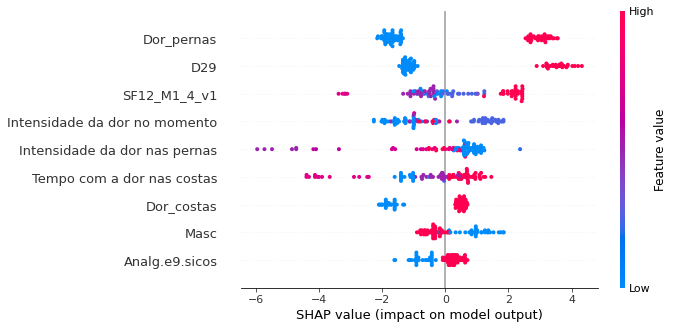

In [16]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


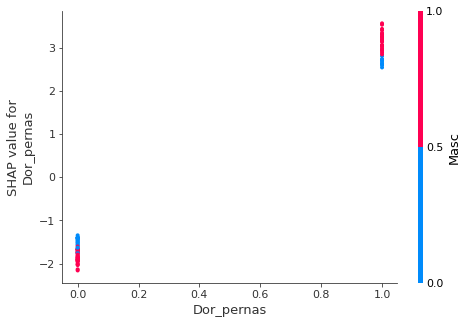

In [17]:
shap.dependence_plot("Dor_pernas", shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


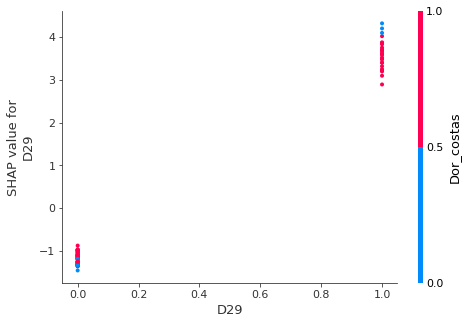

In [18]:
shap.dependence_plot("D29", shap_values, X_train)